# Trabajo practico 1: Clasificiones con Decision Trees y Naive Bayes
### Integrantes: Rodrigo Mauriño, Martin Llada, Juan Jose Iguaran

La base de datos consiste en informacion sobre creditos para vivivienda en el estado de Nueva York, EE.UU. y el objetivo del ejercicio es lograr entrenar modelos clasificatorios que permitan predecir si el aplicante n, dados los valores de los atributos X, es elegible para el credito.  <br> Para proceder a entrenar los modelos clasificatorios, es necesario alistar el framework mediante la importacion de las librerias necesarias:

In [1]:
import os
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn import model_selection
from sklearn import tree
import matplotlib.pyplot as plt

Una vez importadas las librerias, es necesario importar el dataset a ser utlizado, asi como una pequeña visualizacion del mismo:

In [2]:
data = pd.read_csv("baseclean.csv")
dataf=data
dataf=dataf.dropna()
dataf.head()

,action_taken,agency_code,applicant_ethnicity,applicant_income_000s,applicant_race_1,applicant_sex,application_date_indicator,census_tract_number,co_applicant_ethnicity,co_applicant_race_1,...,property_type,purchaser_type,sequence_number,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income
0,1,9,3,230.0,6,3,0,319.00,5,8,...,1,0,155085,82700.0,159,2414.0,2077.0,14.770000,7442.0,138.440002
1,1,7,1,66.0,6,1,0,602.02,3,5,...,2,0,37462,95200.0,47,1422.0,1298.0,19.690001,3997.0,85.000000
3,1,5,2,174.0,5,1,0,502.03,2,5,...,1,0,20,95200.0,40,1723.0,1578.0,17.639999,4971.0,119.169998
4,1,9,2,100.0,5,2,0,195.00,5,8,...,1,0,12370,71300.0,378,615.0,738.0,60.779999,3366.0,78.169998
5,1,7,2,155.0,5,1,0,3037.00,2,5,...,1,1,143,109000.0,352,2008.0,2041.0,22.570000,6718.0,87.589996


Puesto que una delas variables, especificamente, el nombre del condado es un string, se procede a realizar una transformacion en numerica mediante label_encoder y luego reemplazar los valores originales por los obtenidos a partir de la transformacion para poder ejecutar el algoritmo. Asi mismo, es necesario transformar la variable objetivo action_taken en binario para poder luego calcular medidas de desempeño, asi que se procede crear una lista que contiene los indices que resultaron en un credito aprobado, para asignar 1 si la entrada esta dentro de los valores de la lista, o 0 en caso contrario::

In [3]:
values = np.array(dataf["county_name"])
integer_encoded = sk.preprocessing.LabelEncoder().fit_transform(values)
dataf.loc[:,"county_name"]=integer_encoded
list = [1,5,6]
dataf['action_taken'].isin(list).astype(int)
target_encoded =dataf['action_taken'].isin(list).astype(int)

/home/juan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 1) Particion de datos
Ahora que los datos se encuentran en un formato apto para el modelo, se procede a ejecutar su particion. Esta particion tendra como varible objetivo la decision tomada, y como parametros las demas columnas. Consistira en un 80% de los datos para desarrollo y en un 20% para test; los datos de desarrollo seran particionados a su vez en un 80% :

In [4]:
X=dataf.iloc[:,1:]
Y=target_encoded
dev_x, test_x, dev_y, test_y = model_selection.train_test_split(X,Y,train_size=0.8, test_size=0.2,random_state=123)
train_X, val_X, train_y, val_y = model_selection.train_test_split(dev_x, dev_y,train_size=0.8, test_size=0.2,random_state=123)

## 2) Arboles de decision

### 2.1) Arbol de altura 3

Se procede a crear un objeto tipo DecisionTreeClassifier con altura maxima altura 3 manteniendo el resto de los hiperparametros en su valor preestablecido, para luego entrenar dicho objeto con las particiones previamente definidas:

In [5]:
dtree= sk.tree.DecisionTreeClassifier(max_depth = 3)
dtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Una vez entrenado el modelo, se procede a estimar el desempeño del modelo utilizando 5-fold cross validation:

In [13]:
acc_results_train = model_selection.cross_val_score(dtree, train_X, train_y, cv=5, scoring='accuracy')
acc_results_train

array([0.76233184, 0.79147982, 0.7752809 , 0.78153153, 0.79504505])

Se puede apreciar que para el arbol entrenado, la precision se encuentra alrededor del 78% aproximadamente. A continuacion se procede a calcular el ROC AUC para el conjunto de entrenamiento:

In [14]:
roc_results_train = model_selection.cross_val_score(dtree, train_X, train_y, cv=5, scoring='roc_auc')
roc_results_train

array([0.84161989, 0.87178371, 0.85619694, 0.86075231, 0.88678241])

Los puntajes obtenidos utilizando roc_auc son superiores a los obtenidos por precision pues se encuentran alrededor del 86%. A continuacion se calcularan las mismas medidas de desempeño utilizando los datos de validacion:

In [8]:
acc_results_val = model_selection.cross_val_score(dtree, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val = model_selection.cross_val_score(dtree, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_val)
print(roc_results_val)

[0.79464286 0.73214286 0.76785714 0.73873874 0.74545455]
[0.88925439 0.85910088 0.84539474 0.82888889 0.80228571]


Es evidente que los valores para amba medidas son muy parecidas a las obtenidas con el set de entrenamiento, por lo que puede concluirse que no se incurrio en overfitting. Se procede a calcular la media y la desviacion estandar de los distintos folds para la precision, tanto para los datos de validacion, como para los de entrenamiento:

In [9]:
print(acc_results_train.mean())
print(acc_results_train.std())
print(acc_results_val.mean())
print(acc_results_val.std())

0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331


Es evidenciable como las medidas de entrenamiento poseen una mayor media y una menor desviacion estandar, lo que es logico pues para el conjunto de validacion, lo errado de la prediccion asi como la dispercion de la misma es mayor que para el conjunto con el cual se entrenaron los datos. Ahora se realizaran las mismas metricas con los datos obtenidos para ROC AUC:

In [15]:
print(roc_results_train.mean())
print(roc_results_train.std())
print(roc_results_val.mean())
print(roc_results_val.std())

0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542


Se observa el mismo patron que el observado en precision: mayor media y menor desvio, comportamiento que obedece a lo anteriormente explicado.

### 2.2) Arboles de diferentes combinaciones


Con el objetivo de tener una comparacion de desempeño al variar los hiperparametros, se procede a entrenar un nuevo arbol de la misma profundidad, pero esta vez utilizando como criterio information gane en lugar de Gini:

In [16]:
dtree_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)
dtree_ig.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Con el nuevo arbol, se calcularan las mismas metricas obtenidas anteriormente:

In [17]:
acc_results_train_ig = model_selection.cross_val_score(dtree_ig, train_X, train_y, cv=5, scoring='accuracy')
roc_results_train_ig = model_selection.cross_val_score(dtree_ig, train_X, train_y, cv=5, scoring='roc_auc')
acc_results_val_ig = model_selection.cross_val_score(dtree_ig, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val_ig = model_selection.cross_val_score(dtree_ig, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_train_ig)
print(roc_results_train_ig)
print(acc_results_val_ig)
print(roc_results_val_ig)

[0.76233184 0.79147982 0.7752809  0.74774775 0.77702703]
[0.84161989 0.87178371 0.85619694 0.85479167 0.88372685]
[0.78571429 0.75       0.76785714 0.73873874 0.74545455]
[0.84502924 0.87737573 0.84539474 0.82888889 0.80228571]


Se puede apreciar los valores de ROC AUC son muy parecidos a los obtenidos utilizando GINI como criterio. A continuacion se entrenaran dos arboles utilizando ambos criterios pero esta vez, con una altura de 6:

In [18]:
dtree_6_gn= sk.tree.DecisionTreeClassifier(max_depth = 6)
dtree_6_gn.fit(train_X, train_y)
dtree_6_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)
dtree_6_ig.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Se calcularan ahora las metricas de costumbre, iniciando con el arbol creado utilizando GINI:

In [30]:
acc_results_train_6 = model_selection.cross_val_score(dtree_6_gn, train_X, train_y, cv=5, scoring='accuracy')
roc_results_train_6 = model_selection.cross_val_score(dtree_6_gn, train_X, train_y, cv=5, scoring='roc_auc')
acc_results_val_6 = model_selection.cross_val_score(dtree_6_gn, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val_6 = model_selection.cross_val_score(dtree_6_gn, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_train_6)
print(roc_results_train_6)
print(acc_results_val_6)
print(roc_results_val_6)

[0.7690583  0.82286996 0.81123596 0.80405405 0.80855856]
[0.83850384 0.90356284 0.87751477 0.86748843 0.88170139]
[0.76785714 0.73214286 0.75892857 0.75675676 0.73636364]
[0.80062135 0.80080409 0.89199561 0.82425926 0.82666667]


Es apreciable la mejora en el desempeño para todas las metricas estudiadas, por lo que es concluible que un arbol de profundidad 6 se ajusta mejor al dataset en cuestion. Ahora se calcularan las mismas metricas para el arbol entrenado a partir de information gane:

In [33]:
acc_results_train_6_ig = model_selection.cross_val_score(dtree_6_ig, train_X, train_y, cv=5, scoring='accuracy')
roc_results_train_6_ig = model_selection.cross_val_score(dtree_6_ig, train_X, train_y, cv=5, scoring='roc_auc')
acc_results_val_6_ig = model_selection.cross_val_score(dtree_6_ig, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val_6_ig = model_selection.cross_val_score(dtree_6_ig, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_train_6_ig)
print(roc_results_train_6_ig)
print(acc_results_val_6_ig)
print(roc_results_val_6_ig)

[0.79596413 0.81838565 0.80898876 0.80405405 0.80630631]
[0.85151793 0.8916027  0.88219823 0.87967593 0.88390046]
[0.75892857 0.75       0.77678571 0.78378378 0.72727273]
[0.84173977 0.84685673 0.85179094 0.87537037 0.8207619 ]


Se puede evidenciar como las metricas son bastante similares a las observadas con la utilizacion de GINI, sin embargo, aunque algunas tuvieron menor desempeño, puede decirse que hubo una leve mejoria. Ahora se entrenara un arbol sin ninguna especificacion de altura maxima para ambos criterios:

In [34]:
dtree_max_gn= sk.tree.DecisionTreeClassifier()
dtree_max_gn.fit(train_X, train_y)
dtree_max_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy')
dtree_max_ig.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

De la misma manera que para el arbol anterior, se calcularan las metricas de costumbre utilizando GINI:

In [35]:
acc_results_train_max = model_selection.cross_val_score(dtree_max_gn, train_X, train_y, cv=5, scoring='accuracy')
roc_results_train_max = model_selection.cross_val_score(dtree_max_gn, train_X, train_y, cv=5, scoring='roc_auc')
acc_results_val_max = model_selection.cross_val_score(dtree_max_gn, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val_max = model_selection.cross_val_score(dtree_max_gn, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_train_max)
print(roc_results_train_max)
print(acc_results_val_max)
print(roc_results_val_max)

[0.77802691 0.77578475 0.77303371 0.78603604 0.76576577]
[0.75844885 0.77365105 0.74137135 0.75916667 0.72888889]
[0.77678571 0.76785714 0.80357143 0.76576577 0.73636364]
[0.74707602 0.69078947 0.71345029 0.76777778 0.73047619]


Es evidente que al no restringir la altura maxima se obtienen mejores resultados para las medidas del precision, tanto para los datos de entrenamiento como para los de validacion, sin embargo, los puntajes de ROC AUC han disminuido hasta un valor semejante al obtenido por el de precision. A continuacion se calculan las metricas basadas en information gane:

In [36]:
acc_results_train_max_ig = model_selection.cross_val_score(dtree_max_ig, train_X, train_y, cv=5, scoring='accuracy')
roc_results_train_max_ig = model_selection.cross_val_score(dtree_max_ig, train_X, train_y, cv=5, scoring='roc_auc')
acc_results_val_max_ig = model_selection.cross_val_score(dtree_max_ig, val_X, val_y, cv=5, scoring='accuracy')
roc_results_val_max_ig = model_selection.cross_val_score(dtree_max_ig, val_X, val_y, cv=5, scoring='roc_auc')
print(acc_results_train_max_ig)
print(roc_results_train_max_ig)
print(acc_results_val_max_ig)
print(roc_results_val_max_ig)

[0.75336323 0.78251121 0.79101124 0.75       0.7454955 ]
[0.72562722 0.73035857 0.76009367 0.73222222 0.68944444]
[0.75892857 0.76785714 0.82142857 0.77477477 0.73636364]
[0.72733918 0.68494152 0.74049708 0.76055556 0.75714286]


Es apreciable que los valores son bastantes semejantes a los obtenidos mediante la utilizacion de GINI.

## 2.3) Tratamiento de datos faltantes

In [54]:
#data.isna().sum().sum()
#int(data.size*0.05)
random.sample(range(0, data.shape[0]), 1)

[3176]

In [108]:
#data2 = data
#data2.iloc[2,2] = np.nan
#data2.iloc[:,2].median()
a = data2.columns[3]
data2[a].groupby(by=train_y).median()[train_y.iloc[6]]


97.0

In [52]:
#random.sample(range(0, 100), 3)


#train_X.shape[1]  # gives number of row count
#count_col = df.shape[1]  # gives number of col count
def outliers(data,clase, por, rell):
    n = int(data.size*(por/100))
    new_data = data
    for i in range(0,n,1):
        col = random.sample(range(0, data.shape[0]), 1)
        row =  random.sample(range(0, data.shape[1]), 1)
        data.iloc[col,row] = np.nan
        if rell == 1:
            
    
    
#pd.isnull(np.nan)

IndentationError: expected an indented block (<ipython-input-52-99df0f2e7d0a>, line 11)

In [37]:
Importance = pd.DataFrame({'Variable': X.columns,
    'Valor':dtree.feature_importances_ })
Importance=Importance.sort_values('Valor',ascending=True)


Text(0.5, 1.0, 'Variables mas importantes')

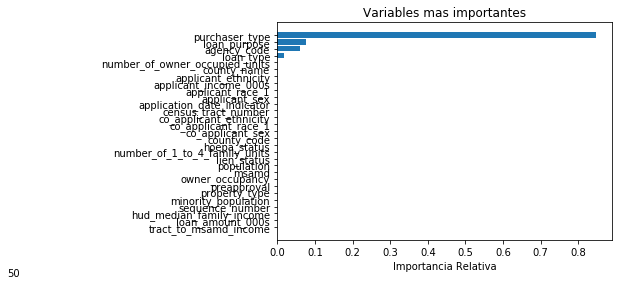

In [38]:
#ANALISIS DE IMPORTANCIA

import matplotlib.pyplot as plt
#Importance['Variable']
y_pos = np.arange(len(Importance['Valor']))

plt.barh(y_pos,Importance['Valor'],align='center')
plt.yticks(y_pos, Importance['Variable'])
plt.xlabel('Importancia Relativa')
plt.figtext(-0.5,0,50)
plt.title('Variables mas importantes')

In [152]:
cv_results.mean()
dtree.decision_path


<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [5]:
predictions=dtree.predict(test_X)
acc=sk.metrics.accuracy_score(test_y, predictions)
Predi = pd.DataFrame({'Class':test_y,
    'Predictions':predictions})
sk.metrics.confusion_matrix(test_y, predictions)
#PREDICE BIEN EL 1. El lo predice de una

NameError: name 'dtree' is not defined

In [161]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=10)
clf.fit(X=X, y=Y)
tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_,clf.best_estimator_)

C:\Users\rmaur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7156411730879816 {'max_depth': 5} DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [304]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:2,2:1,3:2,4:1,5:1,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 2, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [313]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:4,2:2,3:4,4:2,5:3,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 4, 2: 2, 3: 4, 4: 2, 5: 3, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [314]:
predictions=adtree.predict(test_X)
acc=sk.metrics.accuracy_score(test_y, predictions)
acc

0.7068965517241379